In [ ]:
!pip install kornia
!pip install torch==1.5.1+cu101  -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-lightning==0.9.0rc2  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import argparse
import multiprocessing
import torch

from pathlib import Path
from PIL import Image

from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import sys
sys.path.append('/content/drive/My Drive/hateful_memes_data/')
from byol_pytorch import BYOL

from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

### Classes for training

In [2]:
# pytorch lightning module

class SelfSupervisedLearner(pl.LightningModule):
    def __init__(self, net, **kwargs):
        super().__init__()
        self.learner = BYOL(net, **kwargs)
        self.i = 0

    def forward(self, images):
        return self.learner(images)

    def training_step(self, images, _):
        loss = self.forward(images)
        return {'loss': loss}

    def training_epoch_end(self, outputs):
        self.i += 1
        torch.save(self.learner.state_dict(), 
        '/content/drive/My Drive/hateful_memes_data/resnet50_byol_weights_{}.pkl'.format(self.i))
        train_loss_mean = 0
        for output in outputs:
          train_loss = output['loss']
          train_loss_mean += train_loss
        train_loss_mean /= len(outputs)
        tqdm_dict = {'train_loss': train_loss_mean}
        return OrderedDict({'loss': train_loss_mean, 'progress_bar': tqdm_dict, 'log': tqdm_dict})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)

    def on_before_zero_grad(self, _):
        self.learner.update_moving_average()

# images dataset

def expand_greyscale(t):
    return t.expand(3, -1, -1)

class ImagesDataset(Dataset):
    def __init__(self, folder, image_size):
        super().__init__()
        self.folder = folder
        self.paths = []
        print(folder)

        for path in Path(f'{folder}').glob('**/*'):
            _, ext = os.path.splitext(path)
            if ext.lower() in IMAGE_EXTS:
                self.paths.append(path)

        print(f'{len(self.paths)} images found')

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Lambda(expand_greyscale)
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        img = img.convert('RGB')
        return self.transform(img)

### Hyperparameters

In [33]:
resnet = models.resnet50(pretrained=True)
BATCH_SIZE = 32
EPOCHS     = 100
LR         = 3e-4
NUM_GPUS   = 1
IMAGE_SIZE = 256
IMAGE_EXTS = ['.png']
NUM_WORKERS = multiprocessing.cpu_count()

resnet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

TRAIN_DATASET = ImagesDataset('/content/drive/My Drive/hateful_memes_data/train/data', IMAGE_SIZE)
TRAIN_LOADER = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

image_folder = ImageFolder('/content/drive/My Drive/hateful_memes_data/train', transform=resnet_transform)
DATALOADER_FROM_IMG_FODLER = DataLoader(data, batch_size=BATCH_SIZE)

/content/drive/My Drive/hateful_memes_data/train/data
8500 images found


### Training

In [ ]:
model = SelfSupervisedLearner(
    resnet,
    image_size = IMAGE_SIZE,
    hidden_layer = 'avgpool',
    projection_size = 256,
    projection_hidden_size = 4096,
    moving_average_decay = 0.99
)

#  checkpoint_callback = ModelCheckpoint(filepath='/content/drive/My Drive/hateful_memes_data/resnet18_model_checkpoint_{epoch}.ckpt',
#                                  monitor='loss', save_top_k=3)

trainer = pl.Trainer(gpus=NUM_GPUS, max_epochs=EPOCHS) #, checkpoint_callback=checkpoint_callback)
trainer.fit(model, TRAIN_LOADER) 

### Saving embeddings

In [ ]:
byol = BYOL(resnet, IMAGE_SIZE)
byol.load_state_dict(torch.load('/content/drive/My Drive/hateful_memes_data/resnet50_byol_weights_30.pkl'))
byol.eval()

In [ ]:
embs = []
for imgs in iter(DATALOADER_FROM_IMG_FODLER):
    with torch.no_grad(): 
        emb = byol.online_encoder(imgs[0])
    embs.extend(emb)
    
embs = np.array([emb.numpy() for emb in embs])

path = '/content/drive/My Drive/hateful_memes_data/embeddings/'
with open(path + 'resnet50_emb_ep30.npy', 'wb') as f:
    np.save(f, embs)

### T-SNE

In [19]:
def get_tsne(model, epoch):
  path = '/content/drive/My Drive/hateful_memes_data/embeddings/'

  with open(path + model + '_emb_ep0.npy', 'rb') as f:
    random_emb = np.load(f)

  with open(path + model + '_emb_ep' + epoch + '.npy', 'rb') as f:
    trained_emb = np.load(f)

  with open(path + 'labels.npy', 'rb') as f:
    labels = np.load(f)

  tsne_random = TSNE()
  X_random = tsne_random.fit_transform(random_emb)

  tsne_trained = TSNE()
  X_trained = tsne_trained.fit_transform(trained_emb)

  return plot_tsne(model, [0, epoch], X_random, X_trained, labels)

def plot_tsne(model, epochs, tsne_random, tsne_trained, labels):
  tsne = [tsne_random, tsne_trained]

  fig = plt.figure(figsize=(20, 10))
  for i, t in enumerate(tsne):
    plt.subplot(1, 2, i + 1)
    plt.title('{} embeddings after {} epoch'.format(model, epochs[i]))
    sns.scatterplot(t[:,0], t[:,1], hue=labels)
  plt.show()

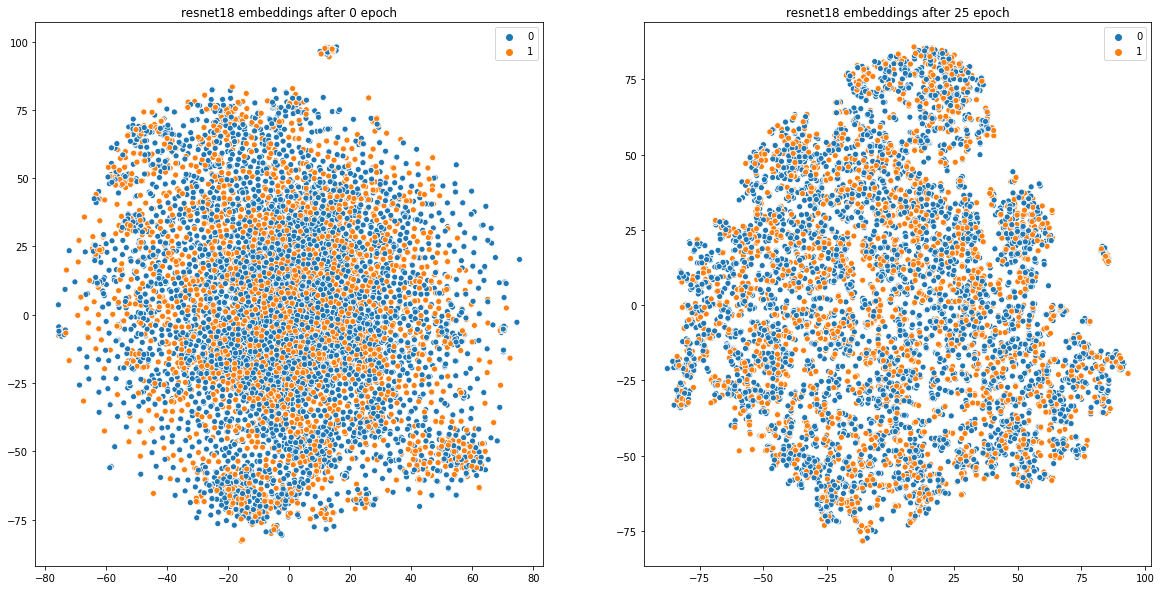

In [17]:
get_tsne('resnet18', '25')

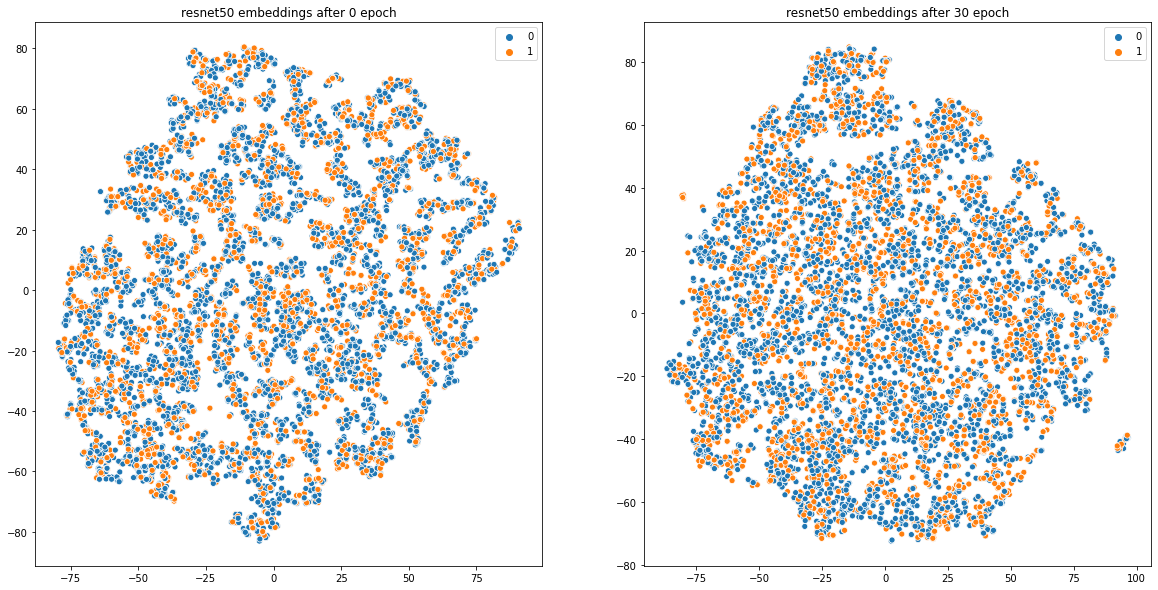

In [20]:
get_tsne('resnet50', '30')

### KNN

In [91]:
def find_nearest_neighbors(model, epoch, n_neighbors=5):
  path = '/content/drive/My Drive/hateful_memes_data/embeddings/'
  with open(path + model + '_emb_ep' + epoch + '.npy', 'rb') as f:
    emb = np.load(f)

  nbrs = NearestNeighbors(n_neighbors=n_neighbors+1)
  nbrs.fit(emb)

  _, indices = nbrs.kneighbors(emb)
  return indices

def plot_knn_examples(knn_idx):
  path = '/content/drive/My Drive/hateful_memes_data/embeddings/'
  with open(path + 'labels.npy', 'rb') as f:
    labels = np.load(f)

  n, k = knn_idx.shape

  for i, imgs_idx in enumerate(knn_idx):
    fig = plt.figure(figsize=(20, 10))

    for j, img_idx in enumerate(imgs_idx):
      plt.subplot(n, k, i * k + j + 1)
      img_folder_idx = knn_idx[i][j]
      img_path, _ = DATALOADER_FROM_IMG_FODLER.dataset.samples[img_folder_idx]
      img_label = labels[img_folder_idx]
      img = plt.imread(img_path)
      plt.title('img num {}, label {}'.format(img_path.rsplit('/')[-1], img_label))
      plt.imshow(img)
  plt.show()


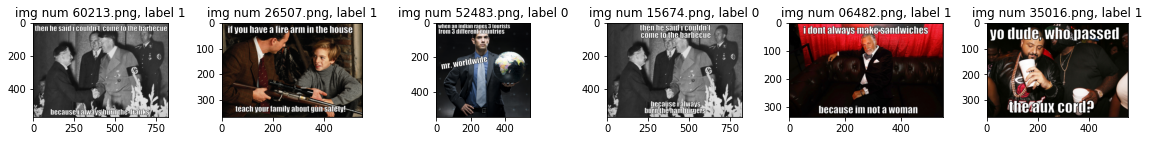

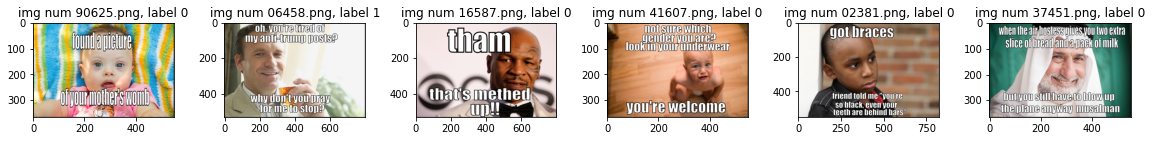

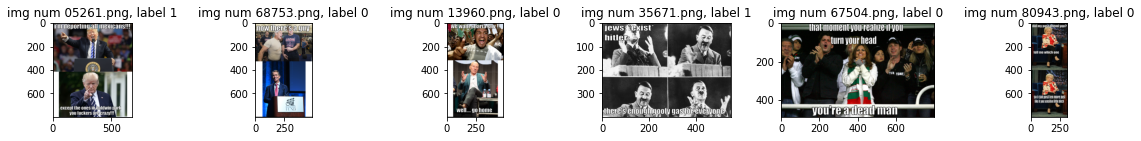

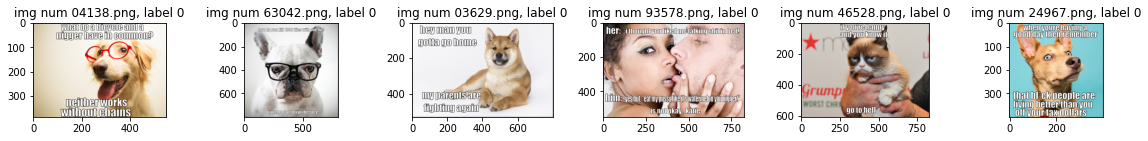

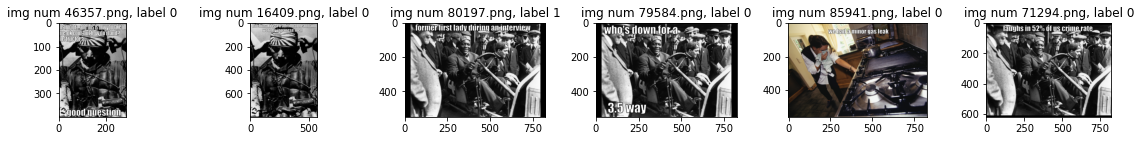

In [92]:
knn_idx = find_nearest_neighbors('resnet18', '25')
random_img = np.random.randint(0, len(knn_idx), 5)
plot_knn_examples(knn_idx[random_img])

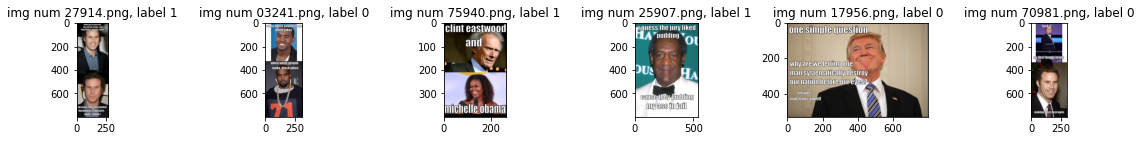

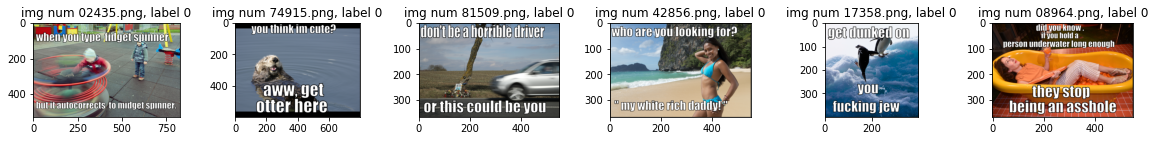

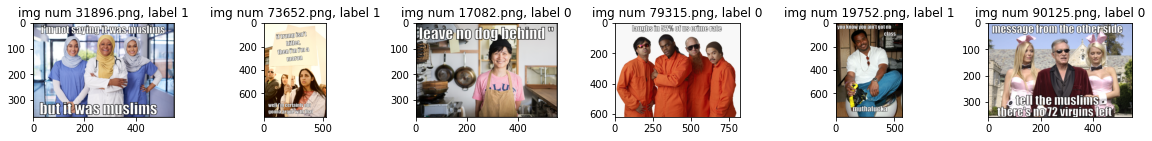

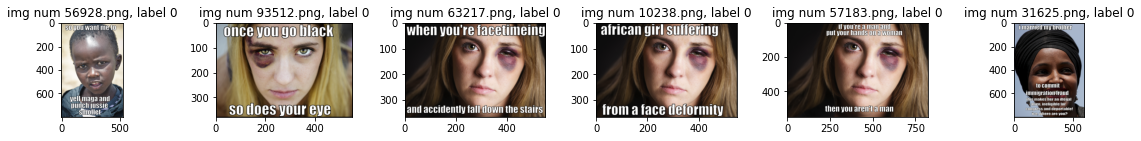

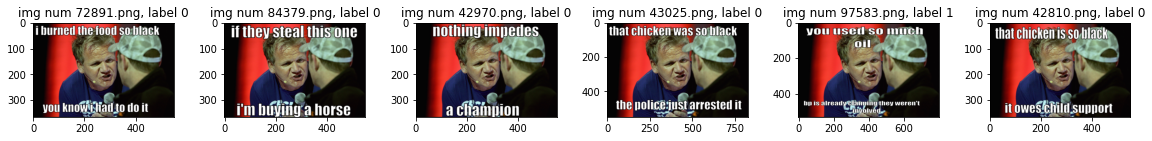

In [93]:
knn_idx = find_nearest_neighbors('resnet50', '30')
random_img = np.random.randint(0, len(knn_idx), 5)
plot_knn_examples(knn_idx[random_img])

In [ ]:
checkpoint_path = '/content/drive/My Drive/hateful_memes_data/resnet18_model_checkpoint_epoch_24.ckpt'

In [ ]:
loaded_model = SelfSupervisedLearner.load_from_checkpoint(checkpoint_path=checkpoint_path)

TypeError: ignored